# Libs and pre-definitions

In [1]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

PATH_FIGS = os.path.join(REPOSITORY_PATH,'notebooks-scripts','paper1','figs')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict
from copy import copy

from time import time

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data
import random


In [5]:
import uncertainty.metrics as metrics

# Analysis

## Definitions

In [6]:
DATA = 'Cifar100'
MODEL_ARC = 'ResNet50'
NAME = MODEL_ARC +'_' + DATA 

data = torch_data.__dict__[DATA](data_dir = DATA_PATH)
if DATA == 'ImageNet':
    model_class = models.pytorch.__dict__[MODEL_ARC.lower()]
    weights_path =  models.pytorch.__dict__[MODEL_ARC+'_Weights']
else:
    model_class = models.__dict__[MODEL_ARC]
    weights_path = os.path.join(PATH_MODELS,MODEL_ARC,DATA)
    WEIGTH_FILE = 1

Files already downloaded and verified
Files already downloaded and verified


## Upload Models

In [8]:
SOFTMAX = True
if DATA == 'ImageNet':
    model = model_class(weights = weights_path.DEFAULT).to(dev)
    data.transforms_test = weights_path.DEFAULT.transforms()
    model.name = NAME
    if SOFTMAX: utils.apply_softmax(model)
else:
    model = model_class(num_classes = data.n_classes, name = NAME, softmax = SOFTMAX).to(dev)
    model.load_state_dict(upload_weights(WEIGTH_FILE ,weights_path))

model.eval()
acc_model = TE.model_acc(model,data.test_dataloader)
rk_model = 1-0.01*acc_model
print(f'Acurácia = {acc_model}')

Acurácia = 79.23


## Plots

### Deterministic

In [9]:
name = NAME + '_Deterministic'
model.eval();

TIME_1 = 4.391596078872681
TIME = 0.043975830078125


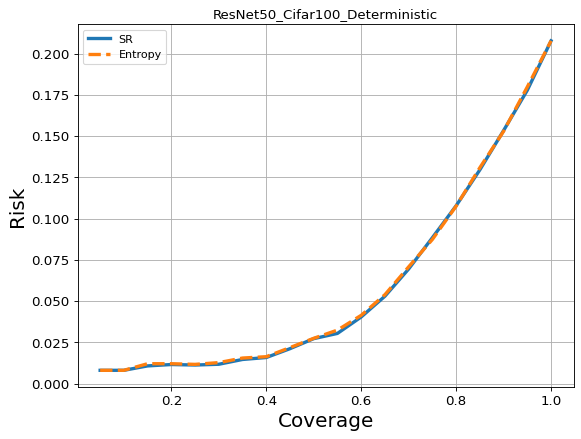

In [10]:

start = time()
RC_det = metrics.selective_metrics(model,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05), name = name)
end = time()
print(f'TIME_1 = {end - start}')


start = time()

RC_det.plot_RC(aurc = False)
end = time()
print(f'TIME = {end - start}')
baseline = RC_det.risk['SR']
#plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

### Deep Ensemble

In [11]:
from uncertainty.ensemble import DeepEnsemble

##### Upload models

In [12]:
models_dict = defaultdict() #dict to store models

if DATA == 'ImageNet':
    for s,w in weights_path._member_map_.items():
        if s == 'DEFAULT': continue
        models_dict[s] = model_class(weights = w).to(dev)
        models_dict[s].name = NAME
        if SOFTMAX: utils.apply_softmax(models_dict[s])
        print(f"model acc = {TE.model_acc(models_dict[s],data.test_dataloader)}")

else:
    for s in weights_files(weights_path):
        print(s)
        models_dict[s.replace('.pt','')] = model_class(num_classes = data.n_classes).to(dev)
        state_dict = torch.load(os.path.join(weights_path,s))
        models_dict[s.replace('.pt','')].load_state_dict(state_dict)
        models_dict[s.replace('.pt','')].eval()
        models_dict[s.replace('.pt','')].softmax = True
        print(f"model acc = {TE.model_acc(models_dict[s.replace('.pt','')],data.test_dataloader)}")
print(f'Ensemble size = {len(models_dict)}')

model acc = 73.388
Ensemble size = 1


In [13]:
name = NAME + '_DeepEnsemble'

model_ens = DeepEnsemble(models_dict,name=name).to(dev)
print(f'Ensemble Total Accuracy: {TE.model_acc(model_ens,data.test_dataloader)}')

Ensemble Total Accuracy: 73.388


##### Analysis

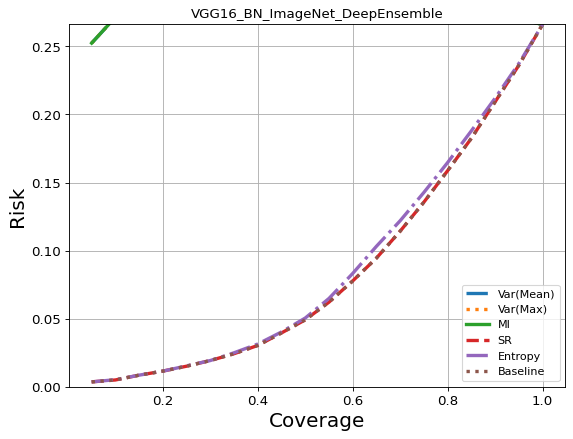

In [14]:
RC_ens = metrics.selective_metrics(model_ens,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC_ens.fix_plot_scale(y_range=(0,rk_model))
RC_ens.plot_RC(baseline = baseline)

### MonteCarlo Dropout

In [15]:
from uncertainty.MonteCarlo_Dropout import MonteCarloDropout
N_SAMPLES = 10

#### MCD Ensemble

In [16]:
name = NAME + '_MCD_Ens'
model_mcd_ens = MonteCarloDropout(model,n_samples = N_SAMPLES, as_ensemble = True,name=name).to(dev)
print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model_mcd_ens,data.test_dataloader,set_eval = False)}')

MCD Ensemble Total Accuracy: 73.21


TIME_1 = 1251.3433632850647
TIME = 0.16273999214172363


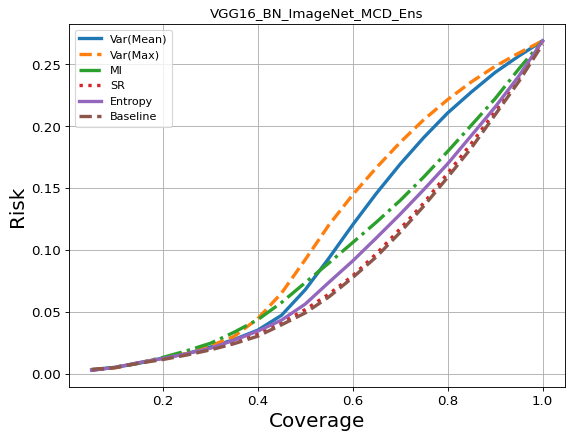

In [17]:
start = time()
RC_mcd = metrics.selective_metrics(model_mcd_ens,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
end = time()
print(f'TIME_1 = {end - start}')
#RC_mcd.fix_plot_scale(y_range=(0,rk_model))

start = time()

RC_mcd.plot_RC(baseline = baseline)
end = time()
print(f'TIME = {end - start}')


#### Deterministic inference

In [18]:
name = NAME + '_MCD_Det'
model_mcd = MonteCarloDropout(model,n_samples = N_SAMPLES, as_ensemble = False,name=name).to(dev)

In [19]:
start = time()
RC_det = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
end = time()
print(f'TIME_1 = {end - start}')
#RC_det.fix_plot_scale(y_range=(0,rk_model))

TIME_1 = 1379.8032467365265


TIME = 0.28692007064819336


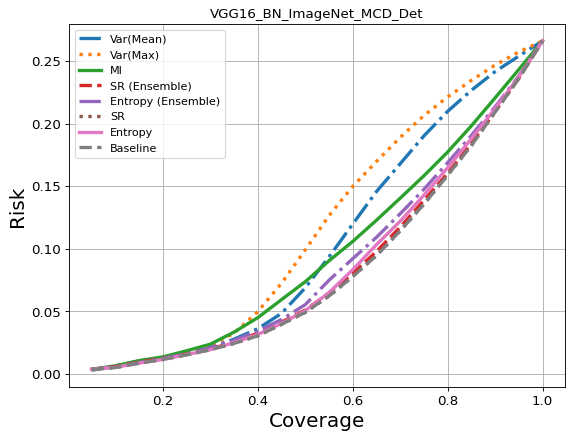

In [20]:
start = time()

RC_det.plot_RC(baseline = baseline)
end = time()
print(f'TIME = {end - start}')

plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

### Monte Carlo Batch Normalization

In [21]:
from uncertainty.MCBN import MonteCarloBatchNormalization as MCBN
from uncertainty.MCBN import Fast_MCBN
N_SAMPLES = 10

#### MC Ensemble

In [22]:
name = NAME + '_MCBN_Ens'
dataloader_bn = torch.utils.data.DataLoader(copy(data.test_data),batch_size= 64, shuffle = True)

model_mcbn = MCBN(model,n_samples = N_SAMPLES, as_ensemble = True,name = name,batch_loader = dataloader_bn).to(dev)

In [23]:
name = NAME + '_MCBN_Ens'
dataloader_bn = torch.utils.data.DataLoader(copy(data.test_data),batch_size= 64, shuffle = True)

model_mcbn = MCBN(model,n_samples = N_SAMPLES, as_ensemble = True,name = name,batch_loader = dataloader_bn).to(dev)
print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model_mcbn,data.test_dataloader,set_eval = False)}')

MCD Ensemble Total Accuracy: 72.972


In [24]:

#RC.fix_plot_scale(y_range=(0,rk_model))
start = time()
RC = metrics.selective_metrics(model_mcbn,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
end = time()
print(f'TIME_1 = {end - start}')

TIME_1 = 2354.5267639160156


TIME = 0.16224431991577148


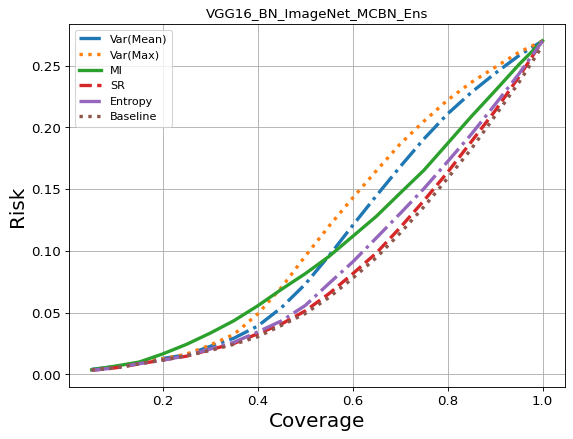

In [25]:
start = time()

RC.plot_RC(baseline = baseline)
end = time()
print(f'TIME = {end - start}')
plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

In [26]:
model_mcbn.reset_normal_mode()

#### Deterministic Inference

In [27]:
name = NAME + '_MCBN_det'
model_mcbn = MCBN(model,n_samples = N_SAMPLES, as_ensemble = False,name = name,batch_loader = dataloader_bn).to(dev)
#print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model_mcbn,data.test_dataloader)}')

In [28]:

start = time()
RC = metrics.selective_metrics(model_mcbn,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
end = time()
print(f'TIME_1 = {end - start}')
#RC.fix_plot_scale(y_range=(0,rk_model))

TIME_1 = 2352.099534034729


In [29]:
print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model_mcbn,data.test_dataloader,set_eval = False)}')

MCD Ensemble Total Accuracy: 72.54


TIME = 0.21373224258422852


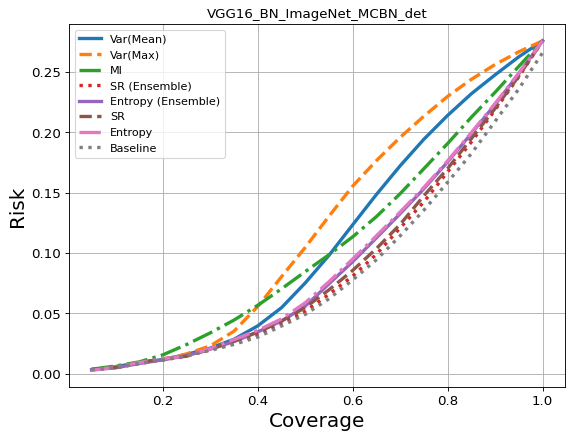

In [30]:
start = time()

RC.plot_RC(baseline = baseline)
end = time()
print(f'TIME = {end - start}')
plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

In [31]:
model_mcbn.reset_normal_mode()

#### FAST MCBN

In [43]:
name = NAME + '_MCBN_fast'
start = time()
model_mcbn = Fast_MCBN(model,n_samples = N_SAMPLES, as_ensemble = True,batch_loader = dataloader_bn).to(dev)
end = time()
print(f'TIME_1 = {end - start}')

#print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model_mcbn,data.test_dataloader)}')

TIME_1 = 3.7367045879364014


In [35]:
start = time()
RC = metrics.selective_metrics(model_mcbn,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
end = time()
print(f'TIME_1 = {end - start}')

TIME_1 = 1239.289605140686


TIME = 0.16850709915161133


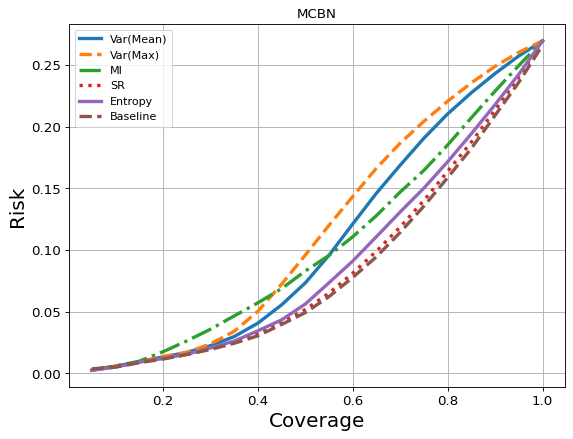

In [36]:
start = time()

RC.plot_RC(baseline = baseline)
end = time()
print(f'TIME = {end - start}')

In [37]:
print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model_mcbn,data.test_dataloader,set_eval = False)}')

MCD Ensemble Total Accuracy: 73.028


### Test-time augmentation

In [38]:
from uncertainty.TestAugmentation import *

c_list = np.arange(0.05,1.05,0.05)
transforms = [F.hflip,
              Scale(1.04),
              Scale(1.1),
              #Rotate(15),
              #Rotate(-15),
              Multiply(0.8),
              Multiply(1.2),
              Add(0.1),
              Add(-0.1),
              FiveCrop(32,4)]

In [39]:
name = NAME + '_TTA'
TTA_model = TTA(model,as_ensemble = False, transforms = transforms,name = name).to(dev)

In [40]:
RC = metrics.selective_metrics(TTA_model,data.test_dataloader, c_list = c_list)
#RC.fix_plot_scale(y_range=(0,rk_model))

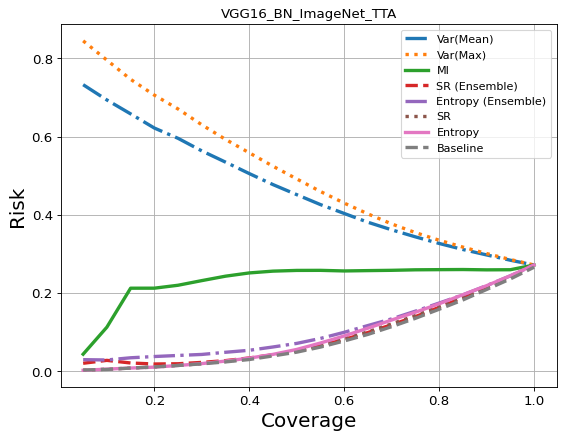

In [41]:
RC.plot_RC(baseline = baseline)

### One VS All

In [18]:
sigmoid_path = os.path.join(weights_path,'OneVSAll')
model_sig = model_class(num_classes = data.n_classes, name = NAME, softmax = True).to(dev)
model_sig.eval()
try:
    model_sig.classifier_layer = torch.nn.Sequential(model_sig.classifier_layer, torch.nn.Sigmoid())
except:
    model_sig.linear = torch.nn.Sequential(model_sig.linear, torch.nn.Sigmoid())
model_sig.load_state_dict(upload_weights(0,sigmoid_path))

<All keys matched successfully>

In [12]:
RC = metrics.selective_metrics(model_sig,data.test_dataloader)

In [13]:
from copy import copy,deepcopy
def P_slova(output,n_classes):
    with torch.no_grad():
        values,indices = torch.max(output,-1)
        y = torch.nn.functional.one_hot(indices,n_classes) 
        P = values
        s = (1-copy(output)[(1-y).bool()]).view(values.size(0),n_classes-1)
        P *= torch.prod(s,dim=-1)
    return P
def slova_unc(output,n_classes = 100):
    return 1-P_slova(output,n_classes)
def get_MCP(y):

    return torch.max(y,-1).values
def MCP_unc(y):
    return 1-get_MCP(y)

In [14]:
RC.d_uncs = {}

In [19]:
RC.add_uncs({'P_slova':slova_unc,'MCP' : MCP_unc})
baseline = RC.risk['P_slova']

In [20]:
sigmoid_path = os.path.join(weights_path,'OneVSAll')
model_sig = model_class(num_classes = data.n_classes, name = NAME, softmax = True).to(dev)
model_sig.eval()
model_sig.linear = torch.nn.Sequential(model_sig.linear, torch.nn.Sigmoid())
model_sig.load_state_dict(upload_weights(0,sigmoid_path))
model_sig.linear = model_sig.linear[0]

RC = metrics.selective_metrics(model_sig,data.test_dataloader)

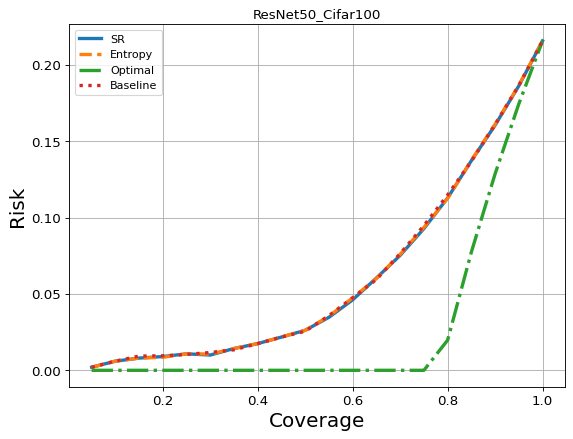

In [22]:
RC.plot_RC(baseline=baseline, optimum = True)

### MIMO

In [42]:
from uncertainty.mimo import MIMO_ensemble
N_ENS = 3
name = f'MIMO_{N_ENS}_' + NAME

mimo_path = os.path.join(weights_path,'MIMO')

TypeError: expected str, bytes or os.PathLike object, not StrEnumMeta

In [ ]:
mimo_model = MIMO_ensemble(model_class,num_classes = data.n_classes,n_ensembles = N_ENS, name = name, softmax = True)
mimo_model.model.load_state_dict(upload_weights(name, mimo_path))
mimo_model.eval()
TE.model_acc(mimo_model,data.test_dataloader)

In [ ]:
RC = metrics.selective_metrics(mimo_model,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.fix_plot_scale(y_range=(0,rk_model))

In [ ]:
RC.plot_RC(aurc = True)